In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing

import sys

In [3]:
def convertHeader(df):
    df['GEO_ID'] = df['GEO_ID'].str[9:]
    df.columns = df.iloc[0]
    df = df.drop(index=0).rename(columns = {"":"GEOID"})
    
    cols = df.columns.tolist()

    for i in range(len(cols)):
        col = cols[i].replace("!!"," ")
        cols[i] = col
    df.columns = cols
    
    return df

def countElemStudents(df):
    elem_members = ['GEOID', 'Estimate Total Male 5 to 9 years', 'Estimate Total Female 5 to 9 years']
    df_elem = df.loc[:,elem_members]
    
    for col in elem_members:
        if col != "GEOID":
            df_elem[col] = df_elem[col].astype('int64')
    df_elem['Total'] = df_elem.iloc[:,1:].sum(axis = 1)
    return df_elem[['GEOID','Total']]

def assignStuToSchools(tract_durham,elem_durham, eps = 0.001):
    spatialIndex = elem_durham.sindex
    elem_durham['elem_Total'] = 0
    for ii in tract_durham.index:
        bgeom = tract_durham.loc[ii,'geometry']
        possibleIndMatches = list(spatialIndex.intersection(bgeom.bounds))
        possibleMatches = elem_durham.iloc[possibleIndMatches]
        
        if len(possibleMatches) == 1:
            elem_durham.at[possibleIndMatches[0],'elem_Total'] += tract_durham.loc[ii,'Total']
        
        else:
            intersectingAreas = possibleMatches.intersection(bgeom).area
            preciseMatches = possibleMatches[intersectingAreas/bgeom.area > eps]
            
            if len(preciseMatches) == 1:
                
                ind = list(preciseMatches.index)[0]
                elem_durham.at[ind,'elem_Total'] += tract_durham.loc[ii,'Total']
            
            elif len(preciseMatches) > 1:
                totalOverlap = preciseMatches.intersection(bgeom).area.sum()
                
                preciseIndMatches = preciseMatches.index
                preciseMatchAreas = preciseMatches.intersection(bgeom).area
                
                for idx in preciseIndMatches:
                    overlapRatio = preciseMatchAreas.loc[idx]/totalOverlap
                    stu = overlapRatio*tract_durham.loc[ii,'Total']
                    elem_durham.at[idx,'elem_Total'] += int(round(stu))
                    
            else:
                print('Tract {} students have no school to go'.format(ii))
    return elem_durham

In [8]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

In [4]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2018_White.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

OBJECTID facilityid stateid                               name  \
0          1     102760  320319        Creekside Elementary School   
1          4      10537  320313           Easley Elementary School   
2          7     112151  320310          Eastway Elementary School   
3         10     127429  320327      Hope Valley Elementary School   
4         13     133728  320304         Bethesda Elementary School   
5         15      14339  320328   Holt Elementary Language Academy   
6         16      14881  320324       Hillandale Elementary School   
7         18       1490  320348           Mangum Elementary School   
8         21      22310  320320            Glenn Elementary School   
9         25      22950  320315       Eno Valley Elementary School   
10        27      26148  320352    Merrick-Moore Elementary School   
11        32      33118  320360        Oak Grove Elementary School   
12        34      40934  320400       Y.E. Smith Elementary School   
13        36      47425  320363        E.K. Powe Elementary School   
14        39      53893  320332      Forest View Elementary School   
15        42      55957  320339         Lakewood Elementary School   
16        43       5758  320340                Little River School   
17        45      58263  320374   C.C. Spaulding Elementary School   
18        49      63466  320344  Fayetteville St Elementary School   
19        53      74395  320372        Southwest Elementary School   
20        56      83117  320362         Parkwood Elementary School   
21        59      87952  320388     W.G. Pearson Elementary School   
22        60      89140  320376    Spring Valley Elementary School   

                                  disttype   distarea  CreationDa   Creator  \
0   Elementary School Base Assignment Zone  24.173063  2018-07-11  QUAYETRI   
1   Elementary School Base Assignment Zone   7.109131  2018-11-08  QUAYETRI   
2   Elementary School Base Assignment Zone   2.074538  2018-07-11  QUAYETRI   
3   Elementary School Base Assignment Zone   5.368242  2018-07-11  QUAYETRI   
4   Elementary School Base Assignment Zone  27.476374  2018-07-11  QUAYETRI   
5   Elementary School Base Assignment Zone   5.591389  2018-11-08  QUAYETRI   
6   Elementary School Base Assignment Zone   8.937701  2018-07-11  QUAYETRI   
7   Elementary School Base Assignment Zone  63.437868  2018-07-11  QUAYETRI   
8   Elementary School Base Assignment Zone  25.297666  2018-07-11  QUAYETRI   
9   Elementary School Base Assignment Zone  11.340106  2018-07-11  QUAYETRI   
10  Elementary School Base Assignment Zone  14.436503  2018-07-11  QUAYETRI   
11  Elementary School Base Assignment Zone  18.688793  2018-07-11  QUAYETRI   
12  Elementary School Base Assignment Zone   1.165149  2018-07-11  QUAYETRI   
13  Elementary School Base Assignment Zone   4.734793  2020-07-23    GISDIV   
14  Elementary School Base Assignment Zone   9.998637  2020-07-23    GISDIV   
15  Elementary School Base Assignment Zone   2.374437  2018-07-11  QUAYETRI   
16  Elementary School Base Assignment Zone  24.994087  2018-07-11  QUAYETRI   
17  Elementary School Base Assignment Zone   2.145288  2018-07-11  QUAYETRI   
18  Elementary School Base Assignment Zone   1.670427  2018-07-11  QUAYETRI   
19  Elementary School Base Assignment Zone   4.013148  2018-07-11  QUAYETRI   
20  Elementary School Base Assignment Zone  11.920096  2018-07-11  QUAYETRI   
21  Elementary School Base Assignment Zone   0.753805  2018-07-11  QUAYETRI   
22  Elementary School Base Assignment Zone  20.510518  2018-07-11  QUAYETRI   

      EditDate  Editor        ShortName  \
0   2019-02-21  GISDIV        Creekside   
1   2019-02-21  GISDIV           Easley   
2   2019-02-21  GISDIV          Eastway   
3   2019-02-21  GISDIV      Hope Valley   
4   2019-02-21  GISDIV         Bethesda   
5   2019-02-21  GISDIV             Holt   
6   2019-02-21  GISDIV       Hillandale   
7   2019-02-21  GISDIV           Mangum   
8   2019-02-21  GISDIV            Glenn

In [66]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2018_White.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

white_2018 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
white_2018.rename(columns={'elem_Total':'white'}, inplace=True)

In [67]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2018_Asian.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

asian_2018 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
asian_2018.rename(columns={'elem_Total':'asian'}, inplace=True)

In [68]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2018_Black.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

black_2018 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
black_2018.rename(columns={'elem_Total':'black'}, inplace=True)

In [69]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2018_Hispanic.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

hispanic_2018 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
hispanic_2018.rename(columns={'elem_Total':'hispanic'}, inplace=True)

In [70]:
white_2018

OBJECTID stateid  white                                           geometry
0          1  320319    894  POLYGON ((-78.92765 35.90246, -78.92766 35.902...
1          4  320313    276  POLYGON ((-78.89536 36.06718, -78.89689 36.064...
2          7  320310    232  POLYGON ((-78.87466 36.01328, -78.87308 36.013...
3         10  320327    507  POLYGON ((-78.93051 35.97123, -78.93012 35.971...
4         13  320304    721  POLYGON ((-78.85930 35.98430, -78.85902 35.983...
5         15  320328    372  POLYGON ((-78.89666 36.05924, -78.89665 36.059...
6         16  320324    421  POLYGON ((-78.96783 36.06228, -78.96744 36.062...
7         18  320348    286  POLYGON ((-78.92725 36.23886, -78.91532 36.238...
8         21  320320    534  POLYGON ((-78.83219 36.09622, -78.82563 36.092...
9         25  320315    347  MULTIPOLYGON (((-78.89683 36.05926, -78.89683 ...
10        27  320352    397  POLYGON ((-78.75081 36.04745, -78.75113 36.043...
11        32  320360    318  POLYGON ((-78.71072 36.01643, -78.70735 36.011...
12        34  320400    123  POLYGON ((-78.87303 35.99596, -78.87118 35.993...
13        36  320363    633  POLYGON ((-78.94415 36.01224, -78.94413 36.010...
14        39  320332    839  POLYGON ((-78.95925 35.99878, -78.95833 35.998...
15        42  320339    144  POLYGON ((-78.92112 35.99671, -78.92001 35.996...
16        43  320340    306  POLYGON ((-78.82253 36.14059, -78.82208 36.140...
17        45  320374    169  POLYGON ((-78.90461 35.99723, -78.90277 35.996...
18        49  320344     75  POLYGON ((-78.89552 35.97301, -78.89437 35.972...
19        53  320372    284  POLYGON ((-78.92093 35.96536, -78.92014 35.964...
20        56  320362    514  POLYGON ((-78.89155 35.91531, -78.89192 35.914...
21        59  320388     45  POLYGON ((-78.88612 35.99037, -78.88629 35.990...
22        60  320376    235  POLYGON ((-78.84697 35.98757, -78.84454 35.987...

In [71]:
black_2018

OBJECTID stateid  black                                           geometry
0          1  320319     96  POLYGON ((-78.92765 35.90246, -78.92766 35.902...
1          4  320313    184  POLYGON ((-78.89536 36.06718, -78.89689 36.064...
2          7  320310    259  POLYGON ((-78.87466 36.01328, -78.87308 36.013...
3         10  320327    149  POLYGON ((-78.93051 35.97123, -78.93012 35.971...
4         13  320304   1376  POLYGON ((-78.85930 35.98430, -78.85902 35.983...
5         15  320328    545  POLYGON ((-78.89666 36.05924, -78.89665 36.059...
6         16  320324    161  POLYGON ((-78.96783 36.06228, -78.96744 36.062...
7         18  320348     77  POLYGON ((-78.92725 36.23886, -78.91532 36.238...
8         21  320320    373  POLYGON ((-78.83219 36.09622, -78.82563 36.092...
9         25  320315    427  MULTIPOLYGON (((-78.89683 36.05926, -78.89683 ...
10        27  320352    398  POLYGON ((-78.75081 36.04745, -78.75113 36.043...
11        32  320360    405  POLYGON ((-78.71072 36.01643, -78.70735 36.011...
12        34  320400    227  POLYGON ((-78.87303 35.99596, -78.87118 35.993...
13        36  320363    229  POLYGON ((-78.94415 36.01224, -78.94413 36.010...
14        39  320332     99  POLYGON ((-78.95925 35.99878, -78.95833 35.998...
15        42  320339     72  POLYGON ((-78.92112 35.99671, -78.92001 35.996...
16        43  320340    104  POLYGON ((-78.82253 36.14059, -78.82208 36.140...
17        45  320374    296  POLYGON ((-78.90461 35.99723, -78.90277 35.996...
18        49  320344    203  POLYGON ((-78.89552 35.97301, -78.89437 35.972...
19        53  320372    331  POLYGON ((-78.92093 35.96536, -78.92014 35.964...
20        56  320362    531  POLYGON ((-78.89155 35.91531, -78.89192 35.914...
21        59  320388    217  POLYGON ((-78.88612 35.99037, -78.88629 35.990...
22        60  320376    478  POLYGON ((-78.84697 35.98757, -78.84454 35.987...

In [72]:
merged = white_2018.merge(black_2018, on = ['stateid','OBJECTID','geometry'])

In [73]:
merged = merged.merge(hispanic_2018, on = ['stateid','OBJECTID','geometry'])
merged = merged.merge(asian_2018, on = ['stateid','OBJECTID','geometry'])

In [74]:
merged['total'] = merged['white'] + merged['black'] + merged['hispanic'] + merged['asian']


In [75]:
merged['% white'] = merged['white']/merged['total']
merged['% black'] = merged['black']/merged['total']
merged['% asian'] = merged['asian']/merged['total']
merged['% hispanic'] = merged['hispanic']/merged['total']

In [76]:
merged

OBJECTID stateid  white  \
0          1  320319    894   
1          4  320313    276   
2          7  320310    232   
3         10  320327    507   
4         13  320304    721   
5         15  320328    372   
6         16  320324    421   
7         18  320348    286   
8         21  320320    534   
9         25  320315    347   
10        27  320352    397   
11        32  320360    318   
12        34  320400    123   
13        36  320363    633   
14        39  320332    839   
15        42  320339    144   
16        43  320340    306   
17        45  320374    169   
18        49  320344     75   
19        53  320372    284   
20        56  320362    514   
21        59  320388     45   
22        60  320376    235   

                                             geometry  black  hispanic  asian  \
0   POLYGON ((-78.92765 35.90246, -78.92766 35.902...     96       154     74   
1   POLYGON ((-78.89536 36.06718, -78.89689 36.064...    184       172      3   
2   POLYGON ((-78.87466 36.01328, -78.87308 36.013...    259       248      0   
3   POLYGON ((-78.93051 35.97123, -78.93012 35.971...    149       318     10   
4   POLYGON ((-78.85930 35.98430, -78.85902 35.983...   1376       408     36   
5   POLYGON ((-78.89666 36.05924, -78.89665 36.059...    545       392     15   
6   POLYGON ((-78.96783 36.06228, -78.96744 36.062...    161       139     23   
7   POLYGON ((-78.92725 36.23886, -78.91532 36.238...     77        12      0   
8   POLYGON ((-78.83219 36.09622, -78.82563 36.092...    373       502      9   
9   MULTIPOLYGON (((-78.89683 36.05926, -78.89683 ...    427       214     10   
10  POLYGON ((-78.75081 36.04745, -78.75113 36.043...    398       405      7   
11  POLYGON ((-78.71072 36.01643, -78.70735 36.011...    405       279      1   
12  POLYGON ((-78.87303 35.99596, -78.87118 35.993...    227       175      0   
13  POLYGON ((-78.94415 36.01224, -78.94413 36.010...    229       339      9   
14  POLYGON ((-78.95925 35.99878, -78.95833 35.998...     99       490     67   
15  POLYGON ((-78.92112 35.99671, -78.92001 35.996...     72        76     13   
16  POLYGON ((-78.82253 36.14059, -78.82208 36.140...    104        63      0   
17  POLYGON ((-78.90461 35.99723, -78.90277 35.996...    296       122      0   
18  POLYGON ((-78.89552 35.97301, -78.89437 35.972...    203        78      0   
19  POLYGON ((-78.92093 35.96536, -78.92014 35.964...    331       105     20   
20  POLYGON ((-78.89155 35.91531, -78.89192 35.914...    531       211     79   
21  POLYGON ((-78.88612 35.99037, -78.88629 35.990...    217        58      0   
22  POLYGON ((-78.84697 35.98757, -78.84454 35.987...    478       104      2   

    total   % white   % black   % asian  % hispanic  
0    1218  0.733990  0.078818  0.060755    0.126437  
1     635  0.434646  0.289764  0.004724    0.270866  
2     739  0.313938  0.350474  0.000000    0.335589  
3     984  0.515244  0.151423  0.010163    0.323171  
4    2541  0.283747  0.541519  0.014168    0.160567  
5    1324  0.280967  0.411631  0.011329    0.296073  
6     744  0.565860  0.216398  0.030914    0.186828  
7     375  0.762667  0.205333  0.000000    0.032000  
8    1418  0.376587  0.263047  0.006347    0.354020  
9     998  0.347695  0.427856  0.010020    0.214429  
10   1207  0.328915  0.329743  0.005800    0.335543  
11   1003  0.317049  0.403789  0.000997    0.278166  
12    525  0.234286  0.432381  0.000000    0.333333  
13   1210  0.523140  0.189256  0.007438    0.280165  
14   1495  0.561204  0.066221  0.044816    0.327759  
15    305  0.472131  0.236066  0.042623    0.249180  
16    473  0.646934  0.219873  0.000000    0.133192  
17    587  0.287905  0.504259  0.000000    0.207836  
18    356  0.210674  0.570225  0.000000    0.219101  
19    740  0.383784  0.447297  0.027027    0.141892  
20   1335  0.385019  0.397753  0.059176    0.158052  
21    320  0.140625  0.678125  0.000000    0.181250  
22    819  0.286935  0.583639  0.002442    0.126984

In [58]:
merged.to_csv('neighboorhood2018.csv')

In [84]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2010_White.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

white_2010 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
white_2010.rename(columns={'elem_Total':'white'}, inplace=True)

############

tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2010_Asian.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

asian_2010 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
asian_2010.rename(columns={'elem_Total':'asian'}, inplace=True)

###################


tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2010_Black.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

black_2010 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
black_2010.rename(columns={'elem_Total':'black'}, inplace=True)

####################


tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByVariousRaces/2010_Hispanic.csv')
df = convertHeader(df)
df_elem = countElemStudents(df)
# Merge Dataframe with shape file
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

hispanic_2010 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
hispanic_2010.rename(columns={'elem_Total':'hispanic'}, inplace=True)

C:\Users\jaryl\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [85]:
merged2 = white_2010.merge(black_2010, on = ['stateid','OBJECTID','geometry'])
merged2 = merged2.merge(hispanic_2010, on = ['stateid','OBJECTID','geometry'])
merged2 = merged2.merge(asian_2010, on = ['stateid','OBJECTID','geometry'])


In [86]:

merged2['total'] = merged2['white'] + merged2['black'] + merged2['hispanic'] + merged2['asian']
merged2['% white'] = merged2['white']/merged2['total']
merged2['% black'] = merged2['black']/merged2['total']
merged2['% asian'] = merged2['asian']/merged2['total']
merged2['% hispanic'] = merged2['hispanic']/merged2['total']

In [62]:
merged2.to_csv('neighboorhood2010.csv')

In [107]:
compiled = merged2.merge(merged, on = ['stateid','OBJECTID','geometry'], suffixes = ["_2010","_2018"])

In [116]:
compiled['white % diff'] = (compiled['white_2018'] - compiled['white_2010'])
compiled['black % diff'] = (compiled['black_2018'] - compiled['black_2010'])

In [110]:
compiled

OBJECTID stateid  white_2010  \
0          1  320319         531   
1          4  320313         175   
2          7  320310          75   
3         10  320327         444   
4         13  320304         265   
5         15  320328         172   
6         16  320324         266   
7         18  320348         405   
8         21  320320         141   
9         25  320315         193   
10        27  320352         130   
11        32  320360         196   
12        34  320400          33   
13        36  320363         277   
14        39  320332         394   
15        42  320339         135   
16        43  320340         395   
17        45  320374          81   
18        49  320344          26   
19        53  320372         207   
20        56  320362         458   
21        59  320388           5   
22        60  320376         126   

                                             geometry  black_2010  \
0   POLYGON ((-78.92765 35.90246, -78.92766 35.902...         372   
1   POLYGON ((-78.89536 36.06718, -78.89689 36.064...         165   
2   POLYGON ((-78.87466 36.01328, -78.87308 36.013...         412   
3   POLYGON ((-78.93051 35.97123, -78.93012 35.971...         189   
4   POLYGON ((-78.85930 35.98430, -78.85902 35.983...        1123   
5   POLYGON ((-78.89666 36.05924, -78.89665 36.059...         548   
6   POLYGON ((-78.96783 36.06228, -78.96744 36.062...         185   
7   POLYGON ((-78.92725 36.23886, -78.91532 36.238...          28   
8   POLYGON ((-78.83219 36.09622, -78.82563 36.092...         791   
9   MULTIPOLYGON (((-78.89683 36.05926, -78.89683 ...         633   
10  POLYGON ((-78.75081 36.04745, -78.75113 36.043...         547   
11  POLYGON ((-78.71072 36.01643, -78.70735 36.011...         292   
12  POLYGON ((-78.87303 35.99596, -78.87118 35.993...         205   
13  POLYGON ((-78.94415 36.01224, -78.94413 36.010...         146   
14  POLYGON ((-78.95925 35.99878, -78.95833 35.998...         134   
15  POLYGON ((-78.92112 35.99671, -78.92001 35.996...          84   
16  POLYGON ((-78.82253 36.14059, -78.82208 36.140...          97   
17  POLYGON ((-78.90461 35.99723, -78.90277 35.996...         200   
18  POLYGON ((-78.89552 35.97301, -78.89437 35.972...         309   
19  POLYGON ((-78.92093 35.96536, -78.92014 35.964...         218   
20  POLYGON ((-78.89155 35.91531, -78.89192 35.914...         445   
21  POLYGON ((-78.88612 35.99037, -78.88629 35.990...         179   
22  POLYGON ((-78.84697 35.98757, -78.84454 35.987...         193   

    hispanic_2010  asian_2010  total_2010  % white_2010  % black_2010  ...  \
0             159          56        1118      0.474955      0.332737  ...   
1              68          71         479      0.365344      0.344468  ...   
2             171           0         658      0.113982      0.626140  ...   
3             190          75         898      0.494432      0.210468  ...   
4             420          63        1871      0.141635      0.600214  ...   
5             237          22         979      0.175689      0.559755  ...   
6              52          68         571      0.465849      0.323993  ...   
7               5          15         453      0.894040      0.061810  ...   
8             225           0        1157      0.121867      0.683665  ...   
9              60          70         956      0.201883      0.662134  ...   
10            289           1         967      0.134436      0.565667  ...   
11            283          12         783      0.250319      0.372925  ...   
12            212           0         450      0.073333      0.455556  ...   
13             84           8         515      0.537864      0.283495  ...   
14            364          25         917      0.429662      0.146129  ...   
15             48           0         267      0.505618      0.314607  ...   
16             51          27         570      0.692982      0.170175  ...   
17             69           0         350      0.231429      0.571429  ...   


AttributeError: 'LineCollection' object has no property 'legend_kwds'

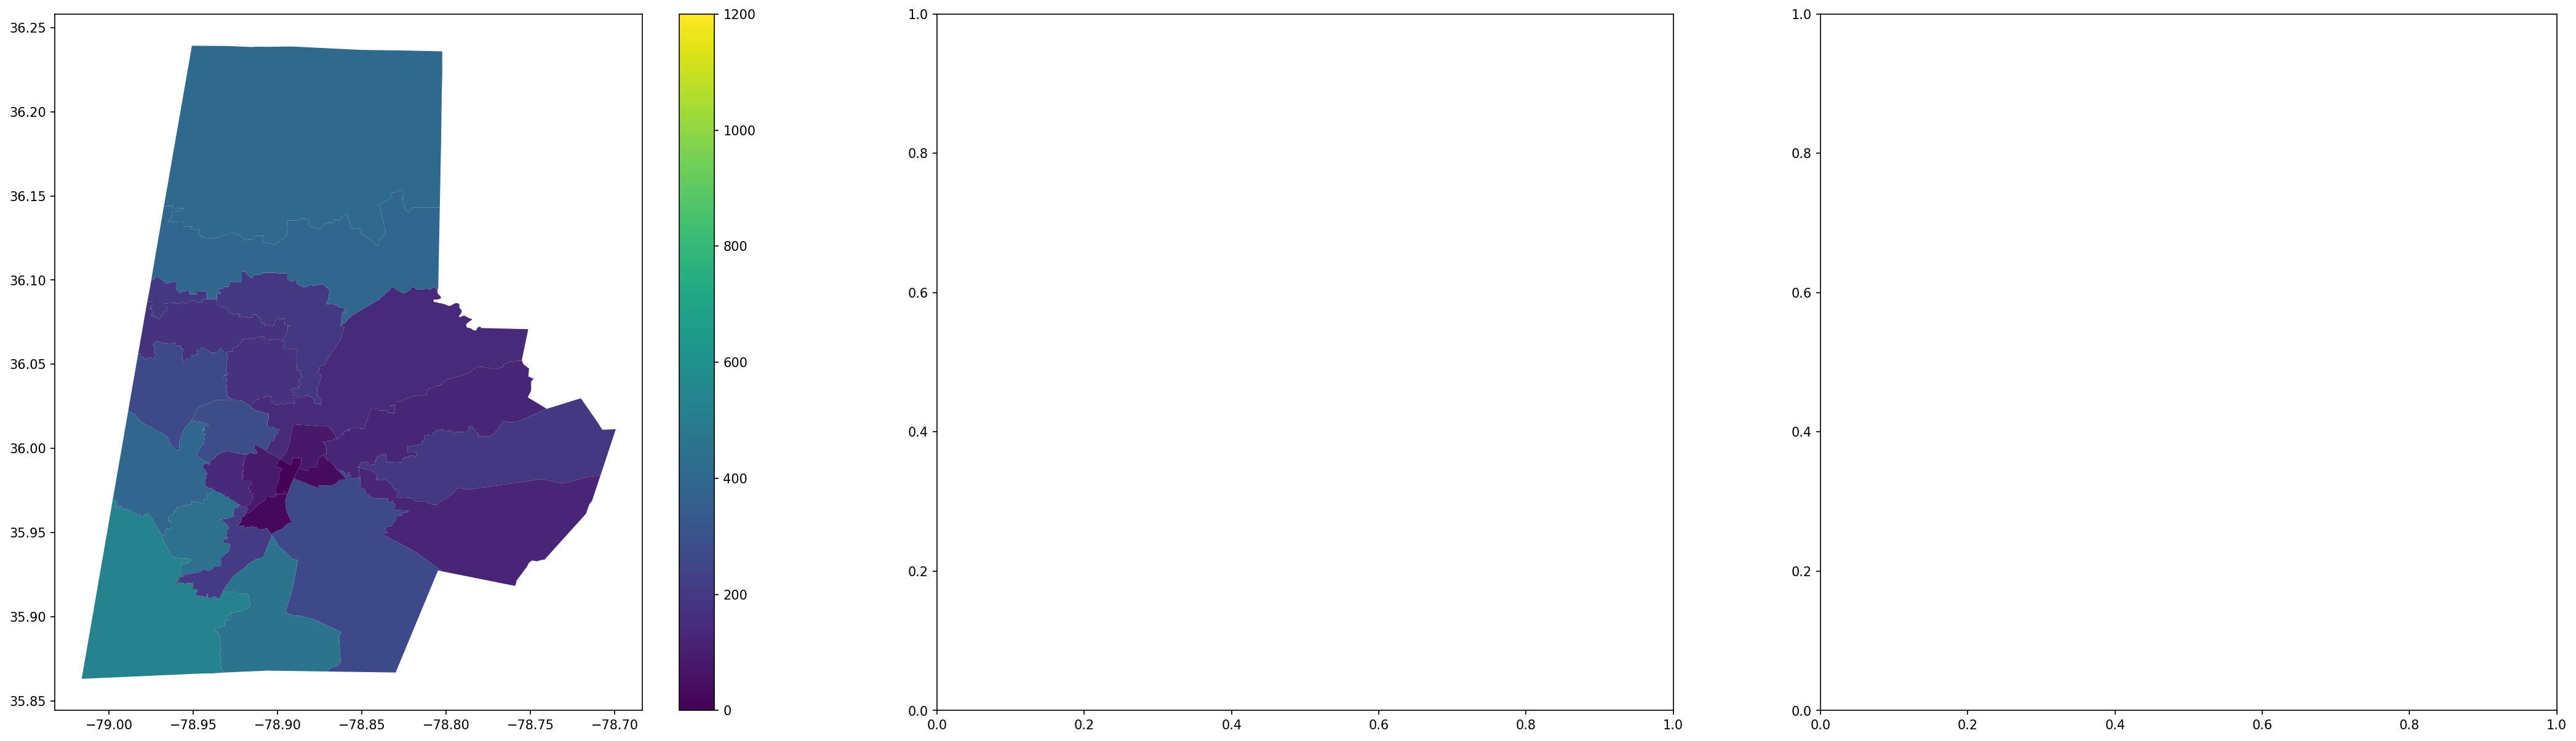

In [134]:
fig, ax  = plt.subplots(1,3, figsize = (35,10), dpi = 150)
year = 2010
merged2.plot(ax = ax[0], legend = True, column ='white', alpha = 1, vmin = 0, vmax = 1200)
merged2.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[0], legend_kwds={'shrink': 0.3})
ax[0].set_title('White Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[0].set_axis_off()

year = 2018
merged.plot(ax = ax[1], legend = True, column ='white', alpha = 1, vmin = 0, vmax = 1200)
merged.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[1].set_title('White Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[1].set_axis_off()

compiled.plot(ax = ax[2], legend = True, column ='white % diff', alpha = 1, vmin = -400, vmax = 400, cmap = 'RdBu')
compiled.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[2].set_title('Difference between 2018 and 2010', fontsize = 30)
ax[2].set_axis_off()

plt.savefig('No of White Children Aged 5 to 9 in ESD.jpg', format = 'jpg')

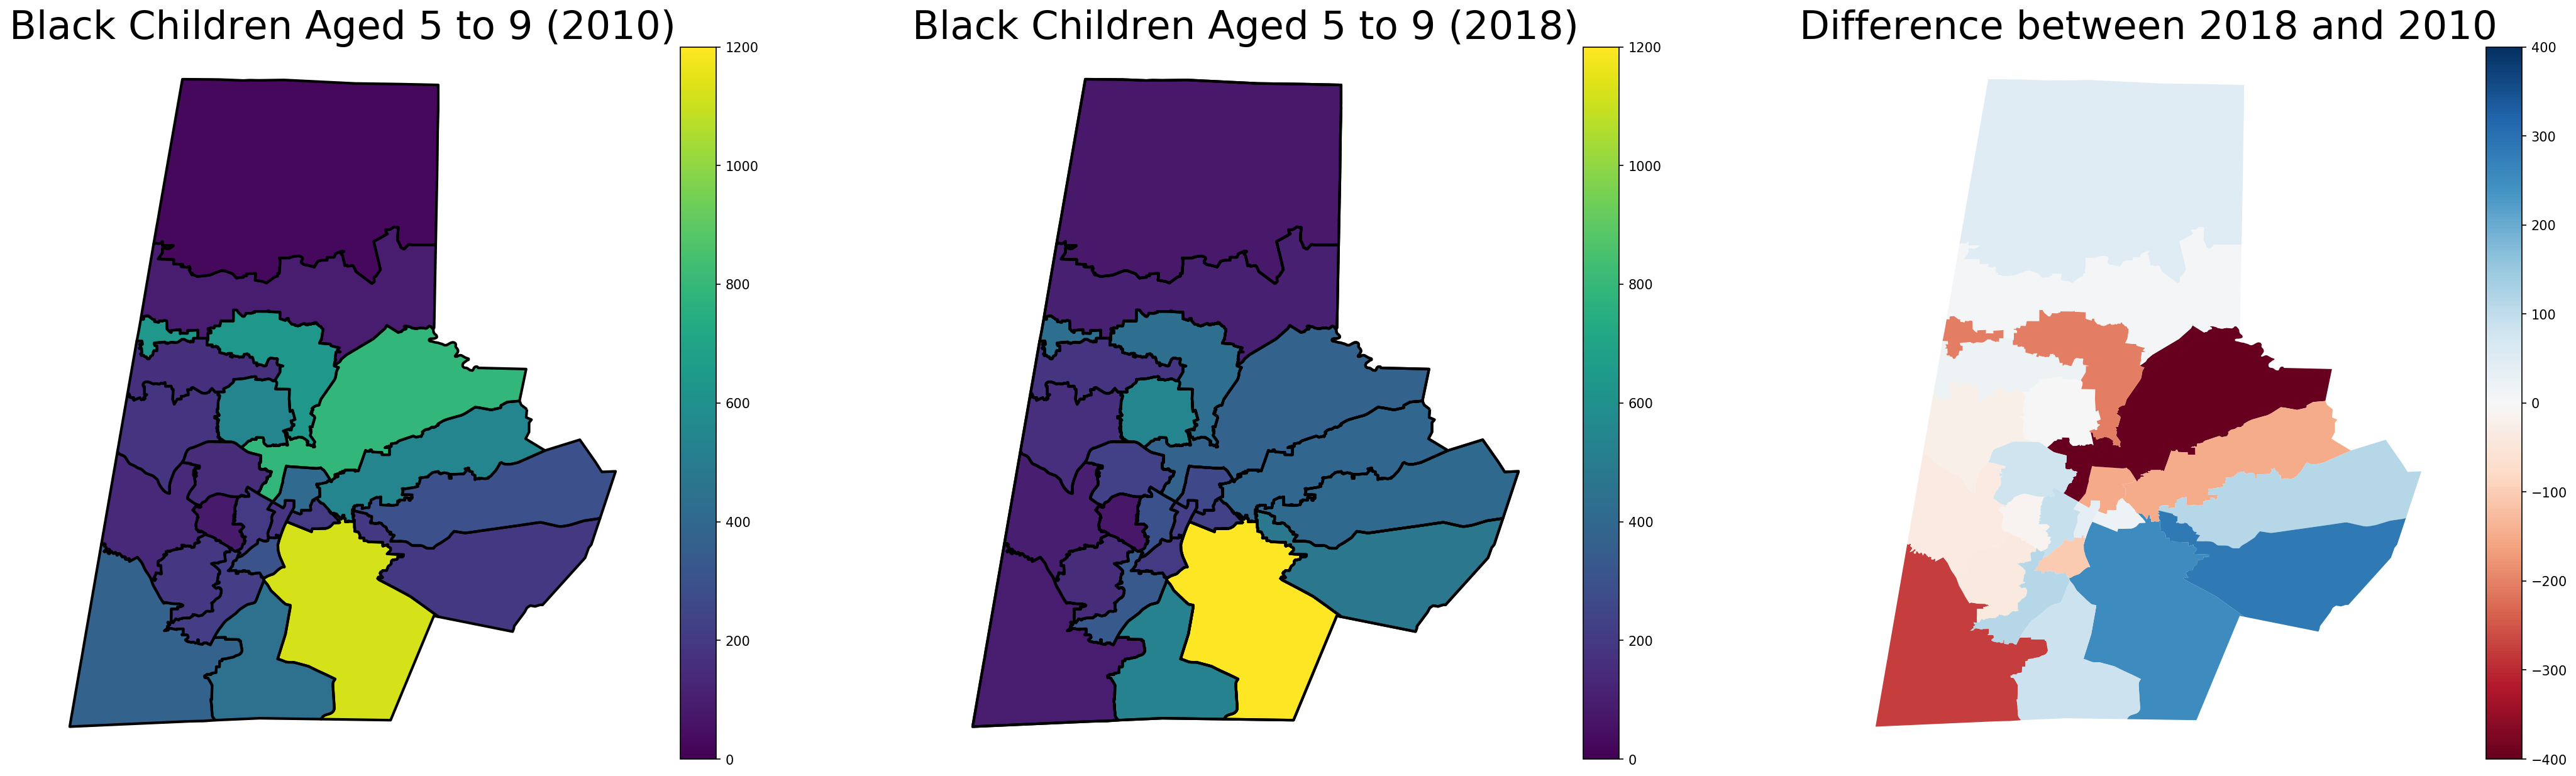

In [133]:
fig, ax  = plt.subplots(1,3, figsize = (35,10), dpi = 150)
year = 2010
merged2.plot(ax = ax[0], legend = True, column ='black', alpha = 1, vmin = 0, vmax = 1200, cmap = 'viridis')
merged2.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[0])
ax[0].set_title('Black Children Aged 5 to 9 ({})'.format(year), fontsize = 30)

ax[0].set_axis_off()

year = 2018
merged.plot(ax = ax[1], legend = True, column ='black', alpha = 1, vmin = 0, vmax = 1200)
merged.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[1].set_title('Black Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[1].set_axis_off()

compiled.plot(ax = ax[2], legend = True, column ='black % diff', alpha = 1, vmin = -400, vmax = 400, cmap = 'RdBu')
compiled.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[2].set_title('Difference between 2018 and 2010', fontsize = 30)
ax[2].set_axis_off()

plt.savefig('No of Black Children Aged 5 to 9 in ESD.jpg', format = 'jpg')

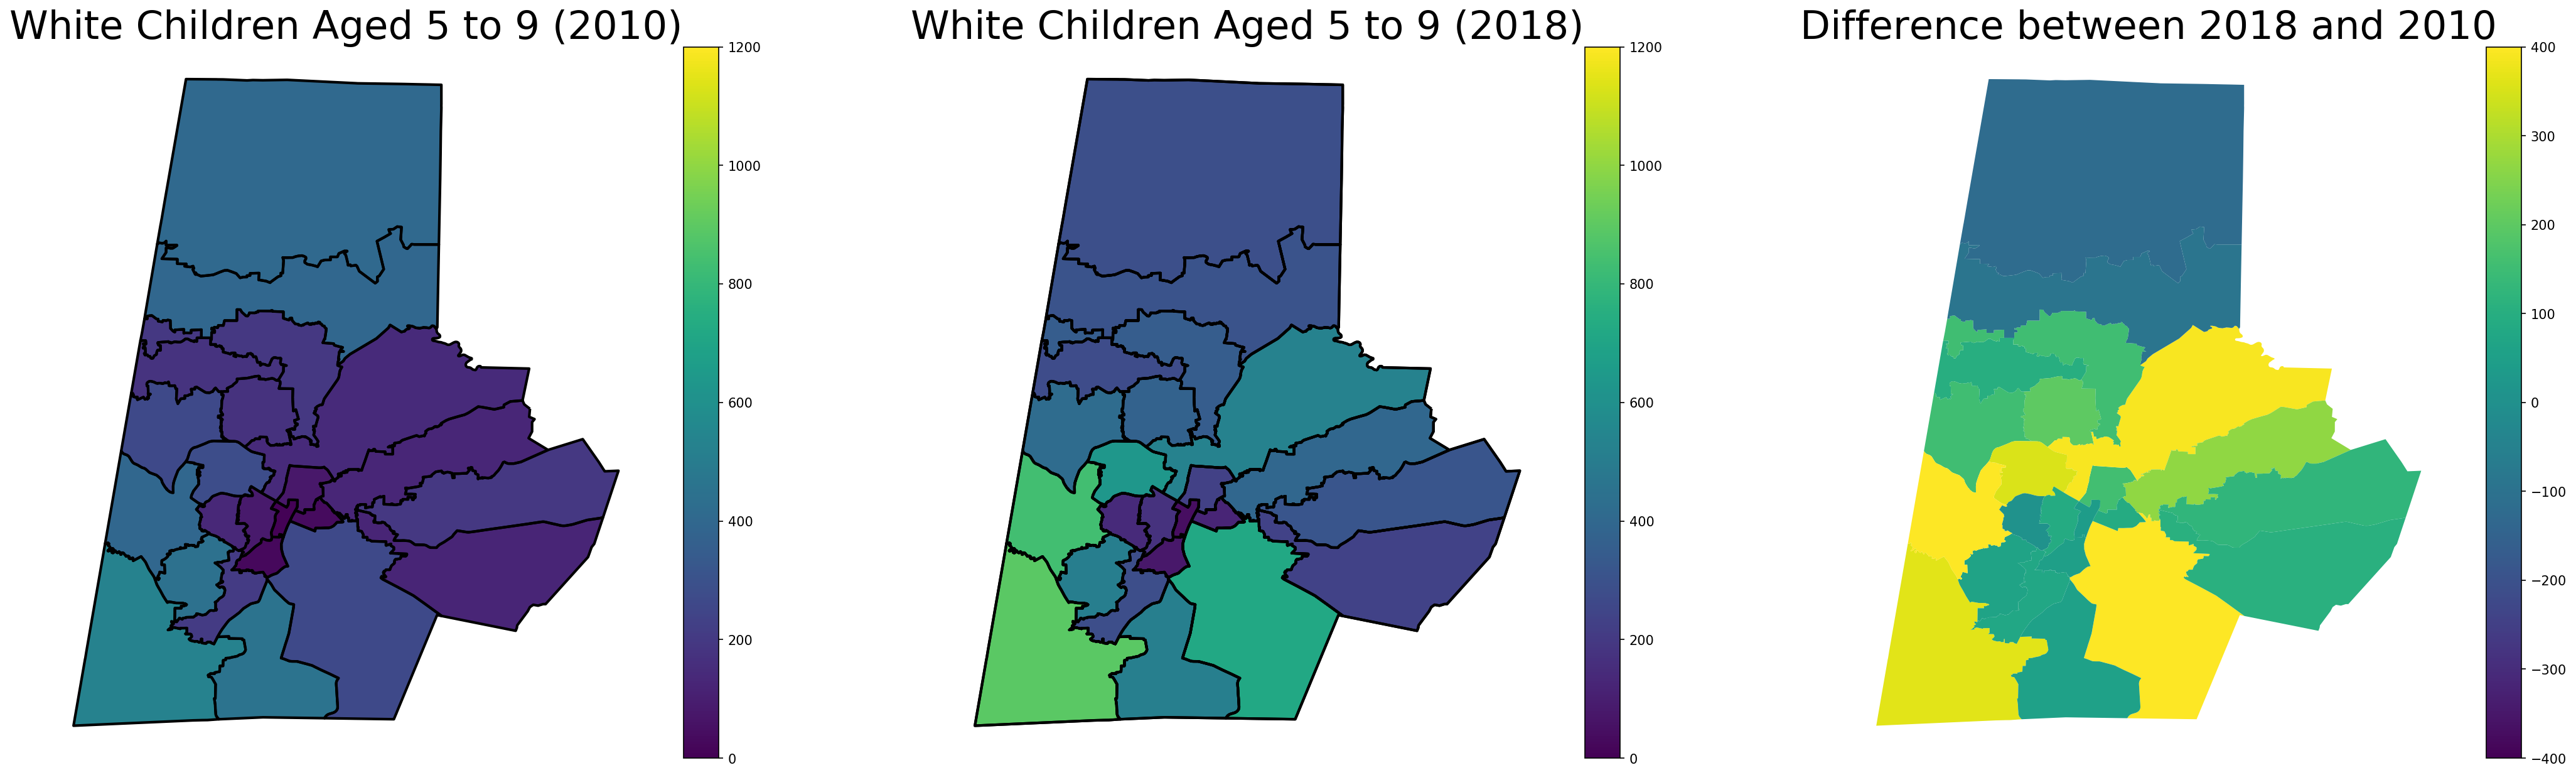

In [121]:
fig, ax  = plt.subplots(1,3, figsize = (35,10), dpi = 150)
year = 2010
merged2.plot(ax = ax[0], legend = True, column ='white', alpha = 1, vmin = 0, vmax = 1200)
merged2.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[0])
ax[0].set_title('White Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[0].set_axis_off()

year = 2018
merged.plot(ax = ax[1], legend = True, column ='white', alpha = 1, vmin = 0, vmax = 1200)
merged.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[1].set_title('White Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[1].set_axis_off()

compiled.plot(ax = ax[2], legend = True, column ='white % diff', alpha = 1, vmin = -400, vmax = 400)
compiled.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[2].set_title('Difference between 2018 and 2010', fontsize = 30)
ax[2].set_axis_off()

plt.savefig('No of White Children Aged 5 to 9 in ESD.jpg', format = 'jpg')

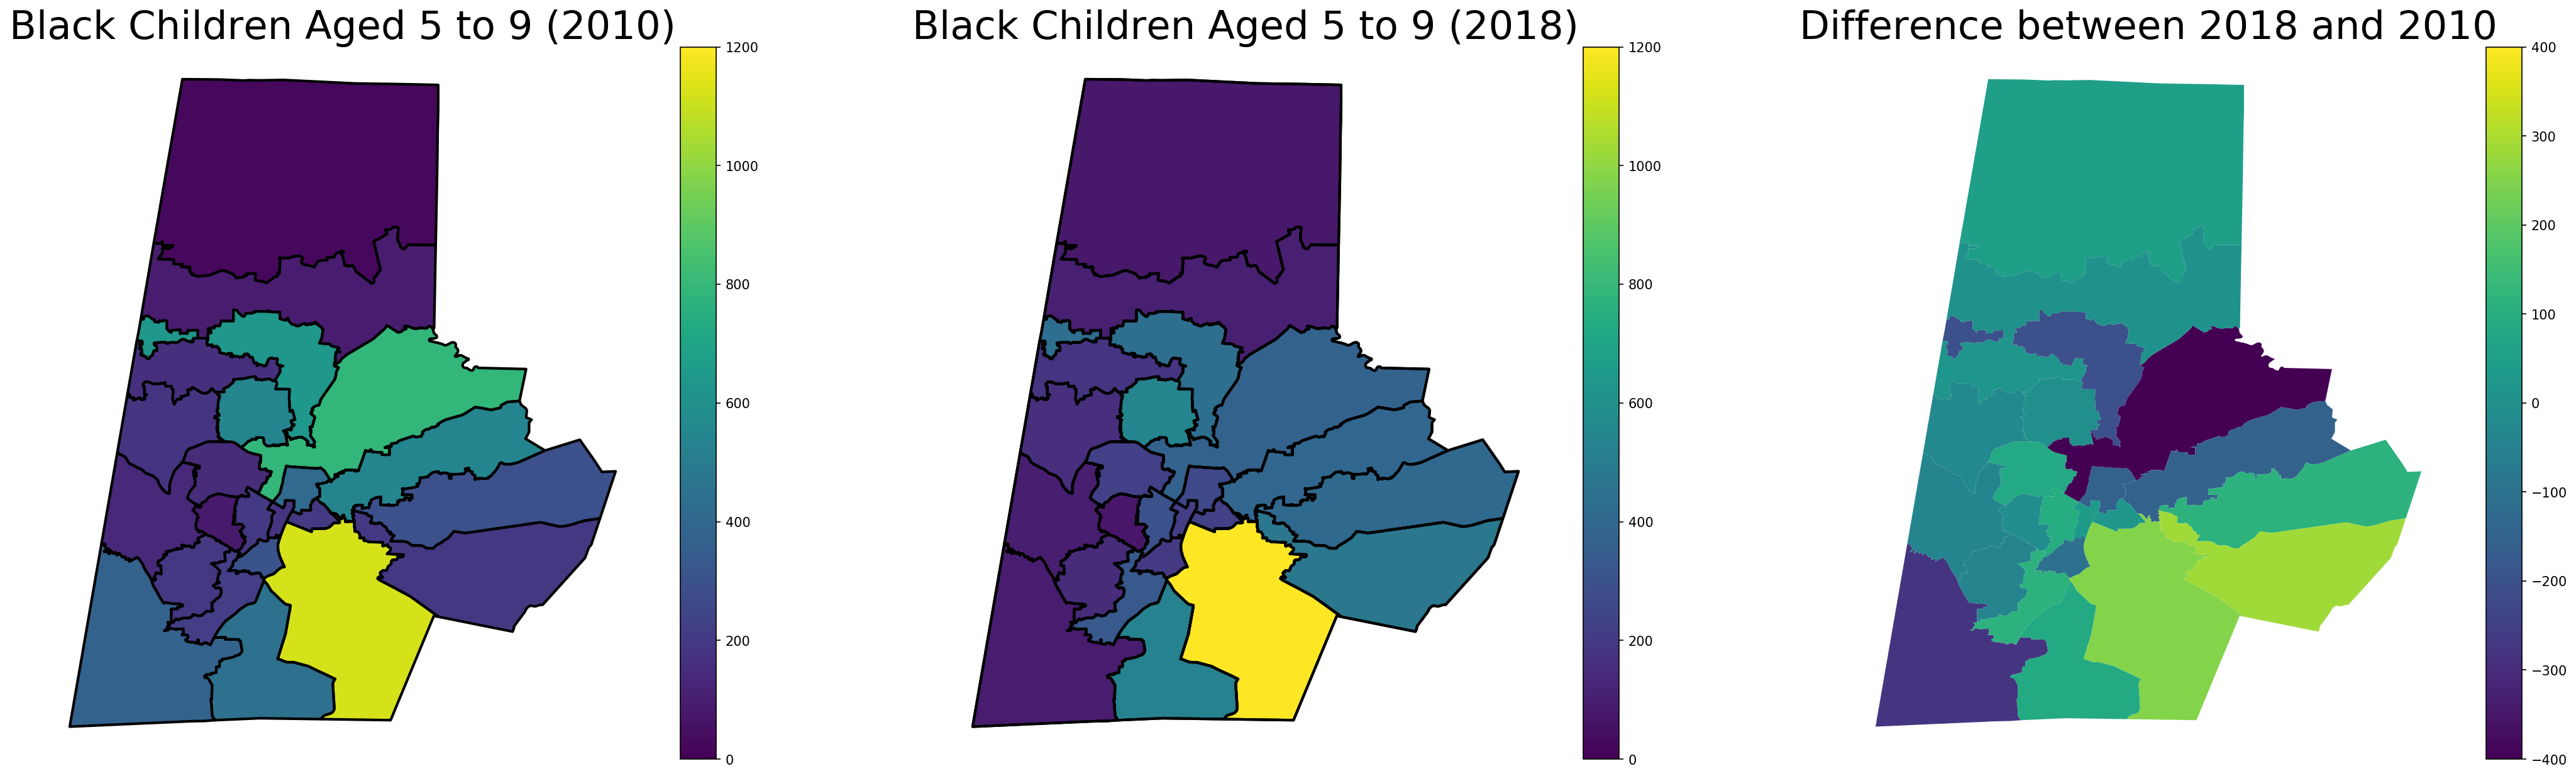

In [122]:
fig, ax  = plt.subplots(1,3, figsize = (35,10), dpi = 150)
year = 2010
merged2.plot(ax = ax[0], legend = True, column ='black', alpha = 1, vmin = 0, vmax = 1200)
merged2.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[0])
ax[0].set_title('Black Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[0].set_axis_off()

year = 2018
merged.plot(ax = ax[1], legend = True, column ='black', alpha = 1, vmin = 0, vmax = 1200)
merged.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[1].set_title('Black Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[1].set_axis_off()

compiled.plot(ax = ax[2], legend = True, column ='black % diff', alpha = 1, vmin = -400, vmax = 400)
compiled.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[2].set_title('Difference between 2018 and 2010', fontsize = 30)
ax[2].set_axis_off()

plt.savefig('No of Black Children Aged 5 to 9 in ESD.jpg', format = 'jpg')

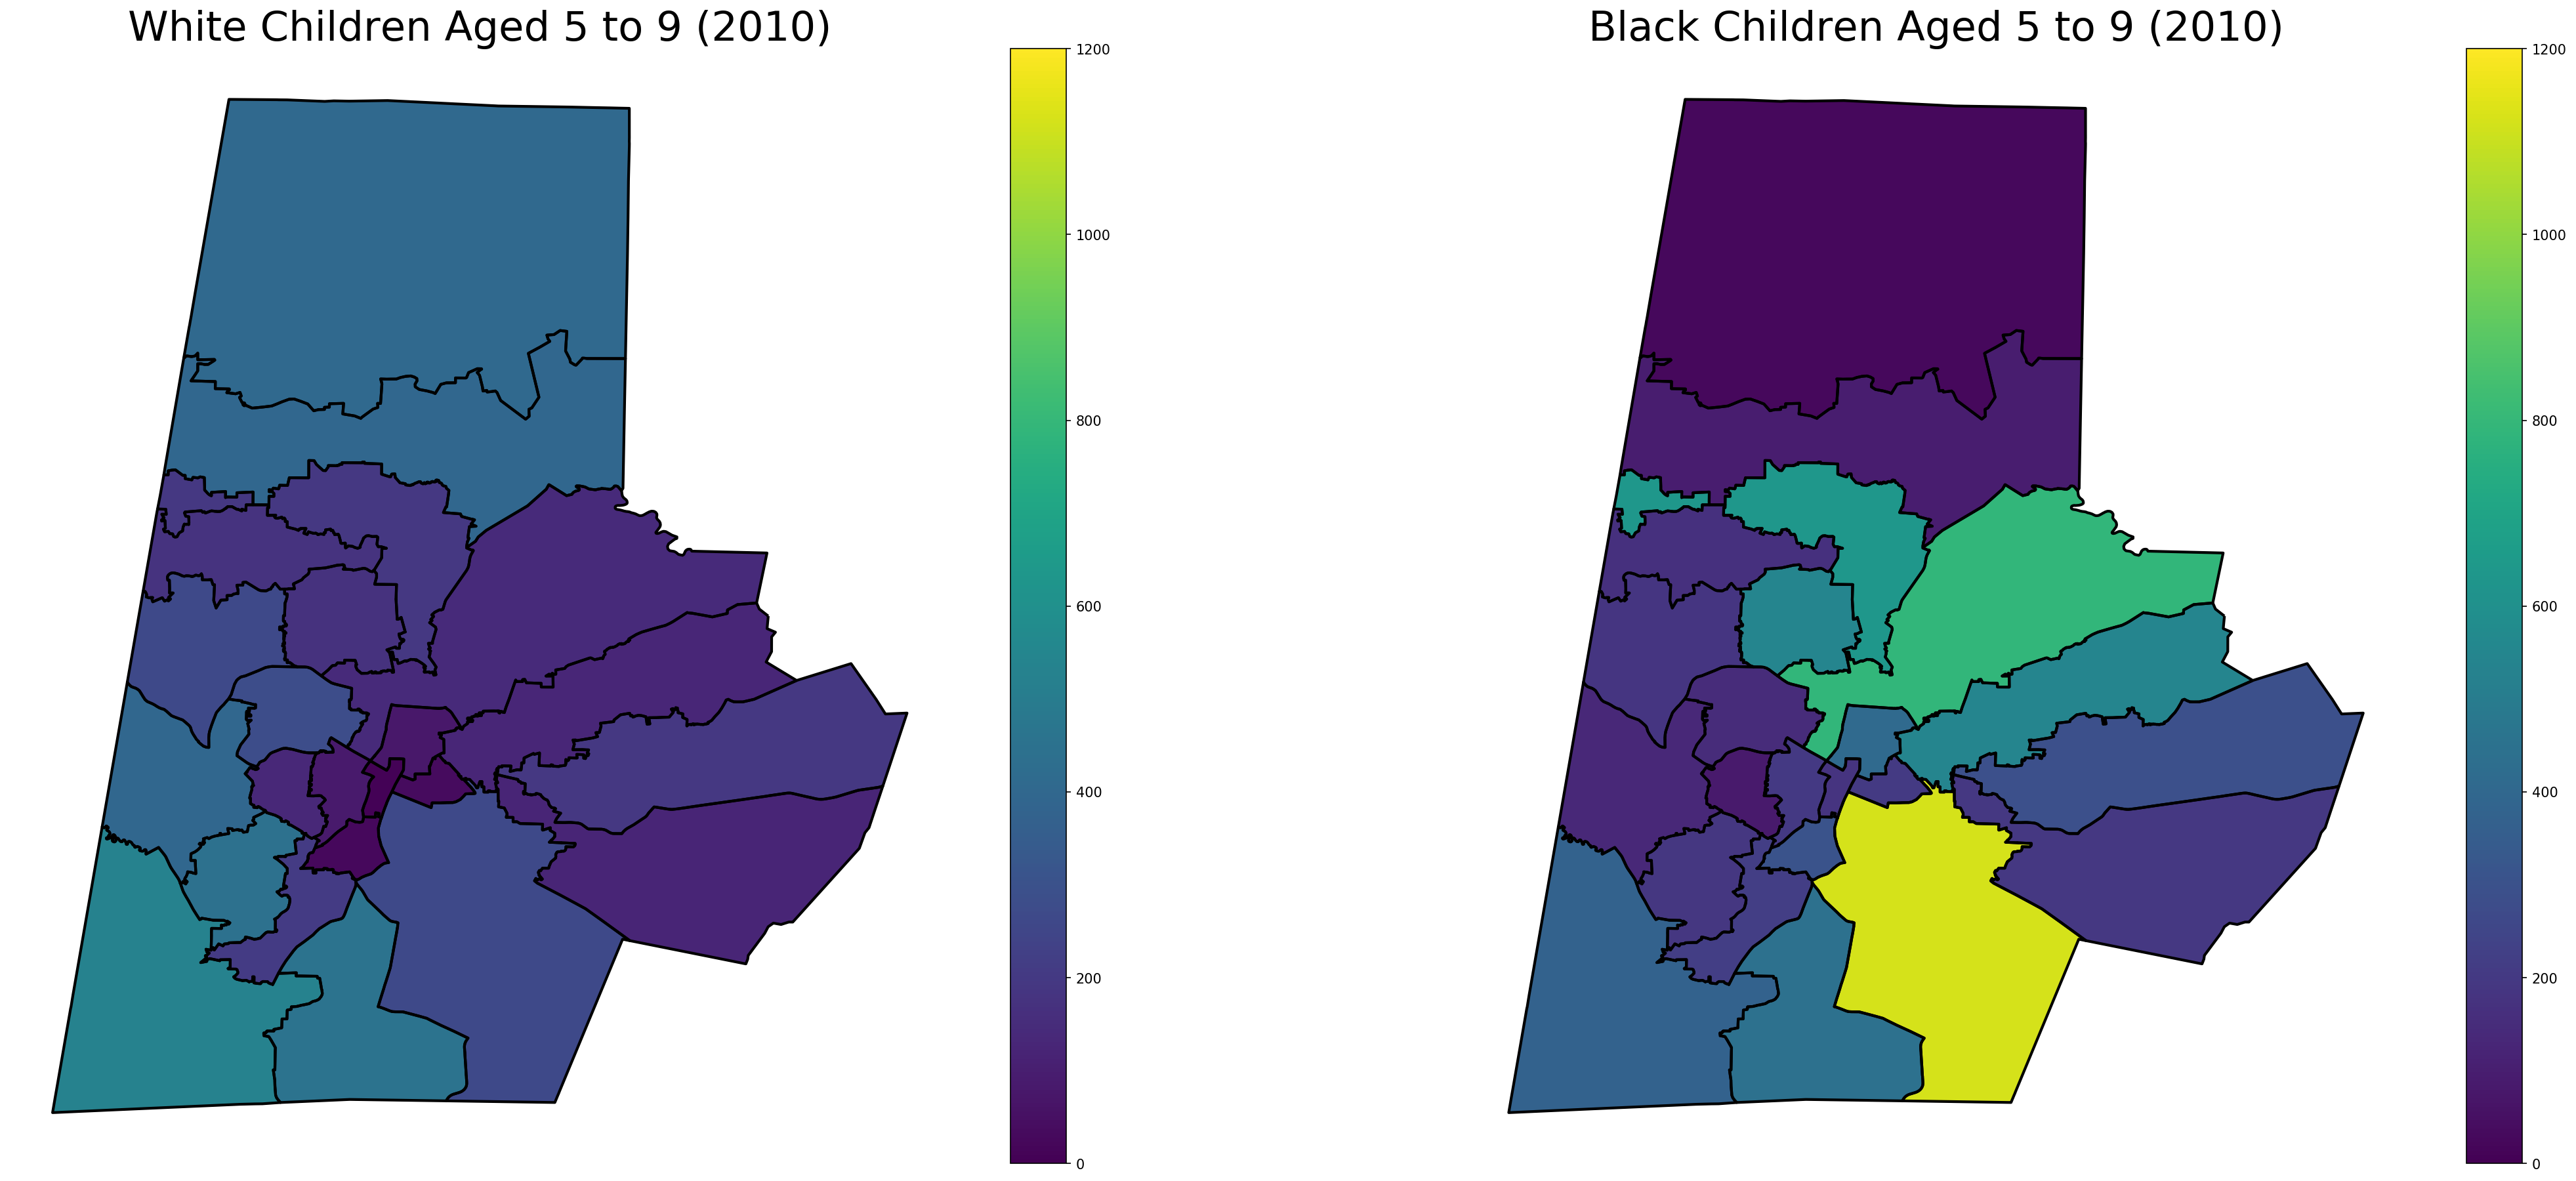

In [102]:
fig, ax  = plt.subplots(1,2, figsize = (35,15), dpi = 150)
year = 2010
merged2.plot(ax = ax[0], legend = True, column ='white', alpha = 1, vmin = 0, vmax = 1200)
merged2.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[0])
ax[0].set_title('White Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[0].set_axis_off()

merged2.plot(ax = ax[1], legend = True, column ='black', alpha = 1, vmin = 0, vmax = 1200)
merged2.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[1].set_title('Black Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[1].set_axis_off()

plt.savefig('No of Children Aged 5 to 9 in ESD {} .jpg'.format(year), format = 'jpg')

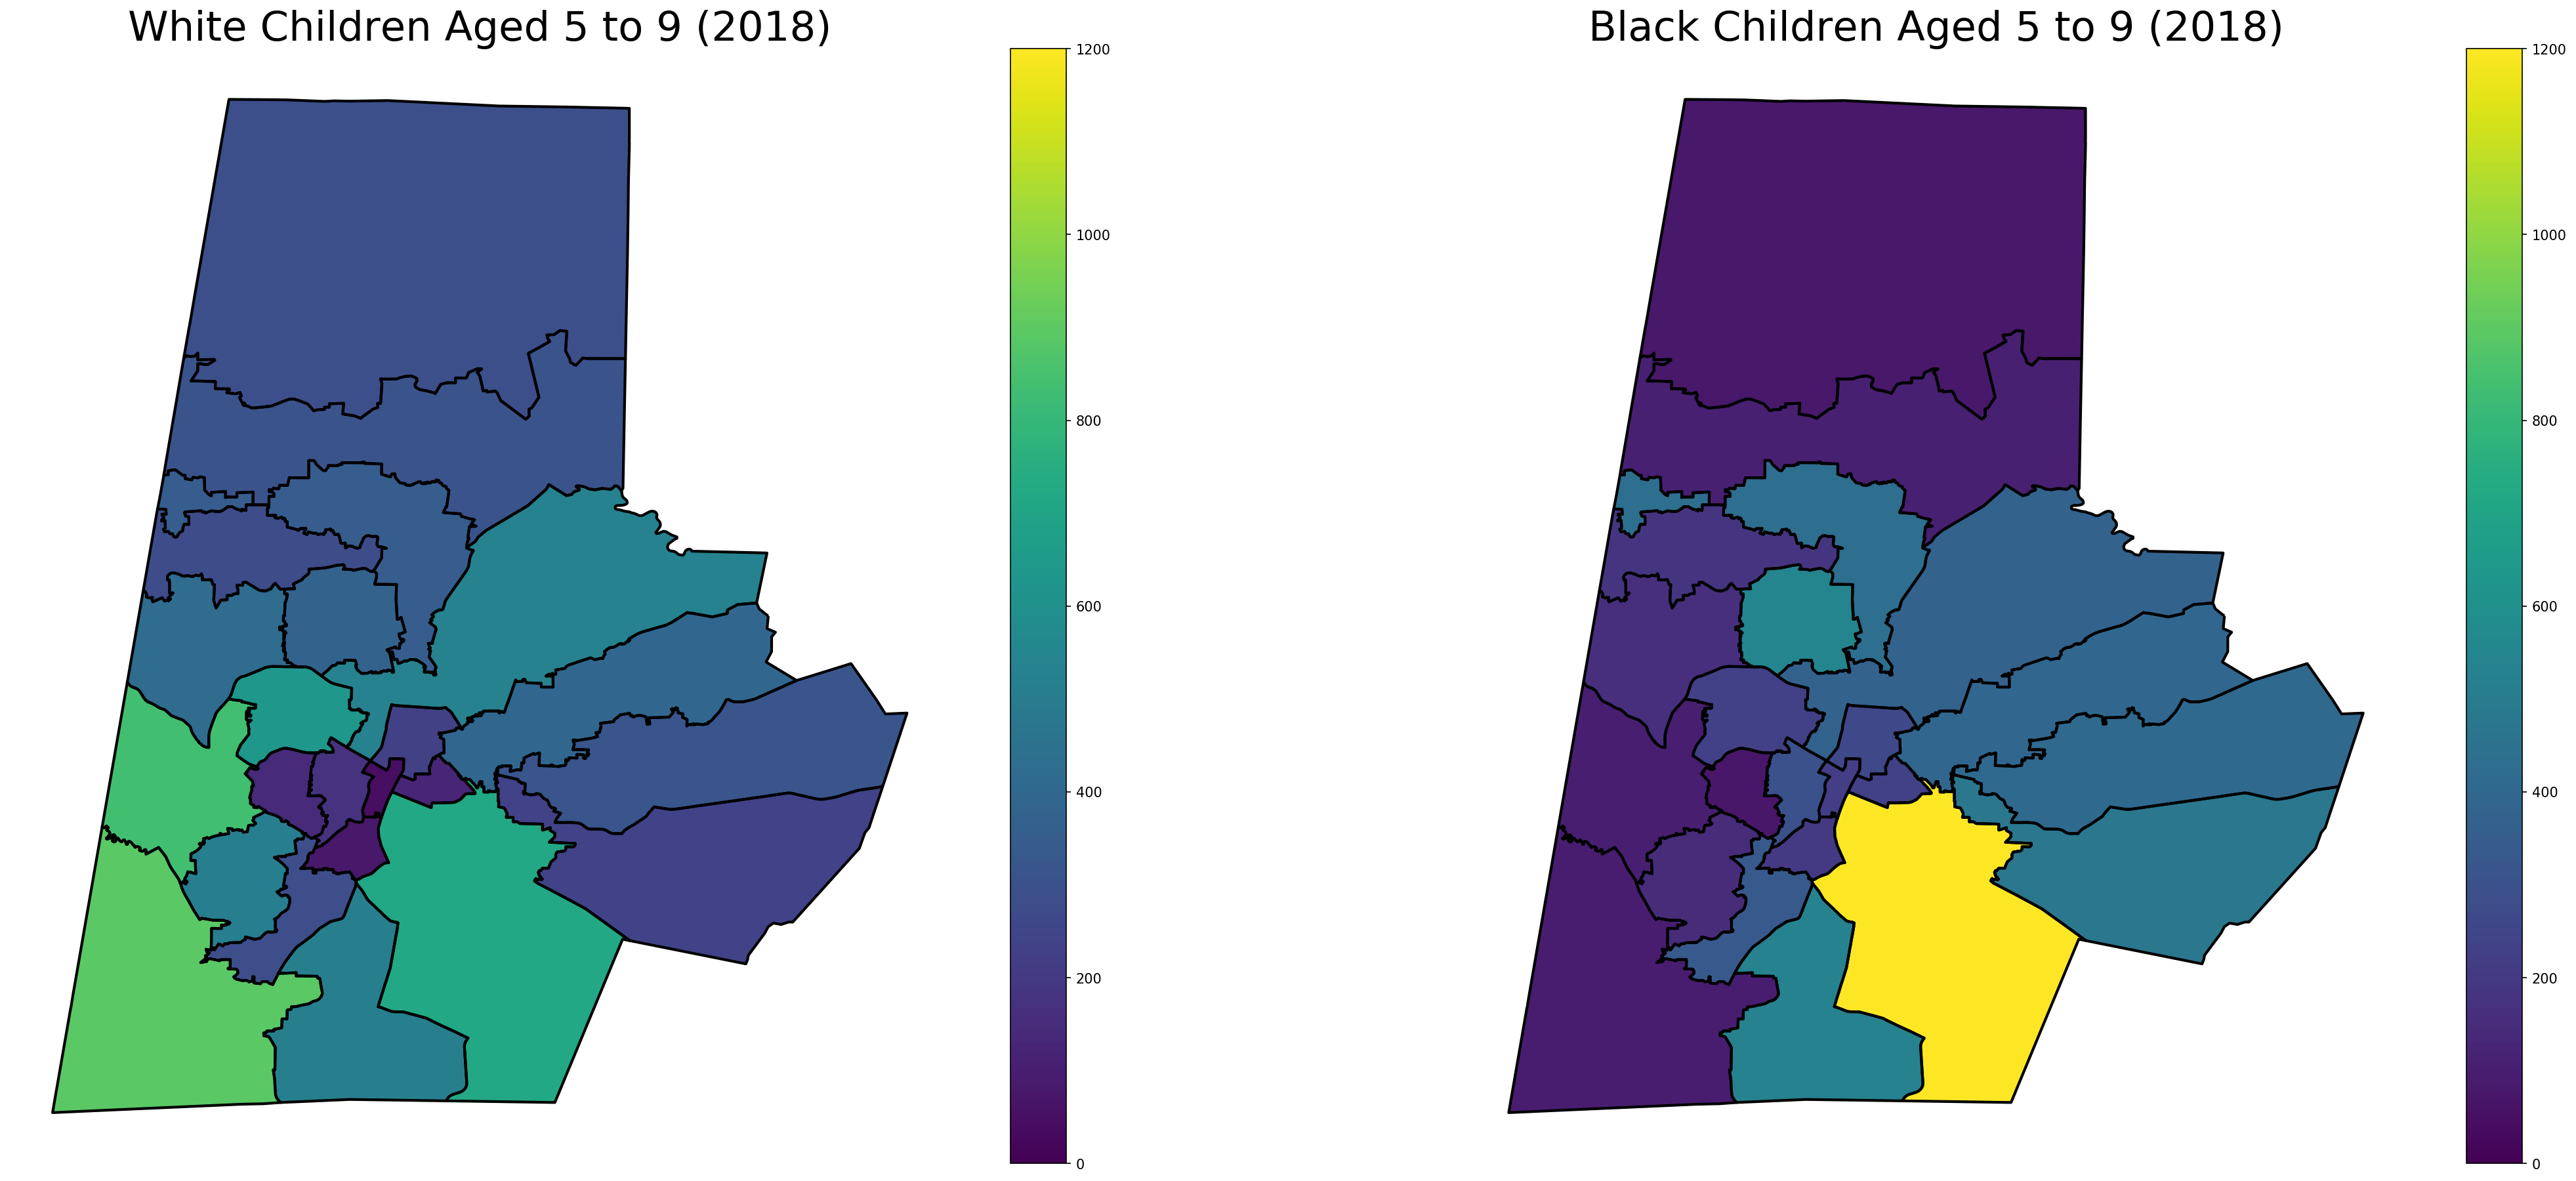

In [101]:
fig, ax  = plt.subplots(1,2, figsize = (35,15), dpi = 150)
year = 2018
merged.plot(ax = ax[0], legend = True, column ='white', alpha = 1, vmin = 0, vmax = 1200)
merged.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[0])
ax[0].set_title('White Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[0].set_axis_off()

merged.plot(ax = ax[1], legend = True, column ='black', alpha = 1, vmin = 0, vmax = 1200)
merged.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[1])
ax[1].set_title('Black Children Aged 5 to 9 ({})'.format(year), fontsize = 30)
ax[1].set_axis_off()

plt.savefig('No of Children Aged 5 to 9 in ESD {} .jpg'.format(year), format = 'jpg')

In [ ]:
fig, ax  = plt.subplots(1,2, figsize = (35,15), dpi = 150)
# plt.rcParams["figure.figsize"] = (40,10)
year = 2010
key = str(year)
df = processed_dfs[key]

df = df[['stateid', 'White Total']]

year = 2018
key = str(year)
new_df = processed_dfs[key]
new_df = new_df.merge(df, how = "inner", on = "stateid")
new_df["White population change"] = ((new_df["White Total_x"] - new_df["White Total_y"])/new_df["White Total_y"])*100


# column_name = "Black Population Total 2010"
plot = new_df.plot(column = "White Total_y",  legend=True, ax = ax[0], vmin = 0, vmax = 410)
new_df.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax[0])

ax[0].set_axis_off()

In [8]:
filenames_lst = [("2010_White","2010_Asian","2010_Black","2010_Hispanic"),("2011_White","2011_Asian","2011_Black","2011_Hispanic"),
 ("2012_White","2012_Asian","2012_Black","2012_Hispanic"),("2013_White","2013_Asian","2013_Black","2013_Hispanic"),
("2014_White","2014_Asian","2014_Black","2014_Hispanic"),("2015_White","2015_Asian","2015_Black","2015_Hispanic"),
("2016_White","2016_Asian","2016_Black","2016_Hispanic"), ("2017_White","2017_Asian","2017_Black","2017_Hispanic"),
("2018_White","2018_Asian","2018_Black","2018_Hispanic")]

df_lst = []

In [9]:
for white,asian,black,hispanic in filenames_lst:
    tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
    elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
    tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

    df = pd.read_csv('PopulationTractByVariousRaces/{}.csv'.format(white))
    df = convertHeader(df)
    df_elem = countElemStudents(df)
    # Merge Dataframe with shape file
    tract_durham = tract_durham.merge(df_elem, on='GEOID')
    #Assign School
    assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

    white_2010 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
    white_2010.rename(columns={'elem_Total':'white'}, inplace=True)

    ############

    tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
    elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
    tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

    df = pd.read_csv('PopulationTractByVariousRaces/{}.csv'.format(asian))
    df = convertHeader(df)
    df_elem = countElemStudents(df)
    # Merge Dataframe with shape file
    tract_durham = tract_durham.merge(df_elem, on='GEOID')
    #Assign School
    assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

    asian_2010 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
    asian_2010.rename(columns={'elem_Total':'asian'}, inplace=True)

    ###################


    tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
    elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
    tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

    df = pd.read_csv('PopulationTractByVariousRaces/{}.csv'.format(black))
    df = convertHeader(df)
    df_elem = countElemStudents(df)
    # Merge Dataframe with shape file
    tract_durham = tract_durham.merge(df_elem, on='GEOID')
    #Assign School
    assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

    black_2010 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
    black_2010.rename(columns={'elem_Total':'black'}, inplace=True)

    ####################


    tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
    elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
    tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

    df = pd.read_csv('PopulationTractByVariousRaces/{}.csv'.format(hispanic))
    df = convertHeader(df)
    df_elem = countElemStudents(df)
    # Merge Dataframe with shape file
    tract_durham = tract_durham.merge(df_elem, on='GEOID')
    #Assign School
    assignStuToSchools(tract_durham,elem_durham, eps = 0.001)

    hispanic_2010 = elem_durham[['OBJECTID','stateid','elem_Total','geometry']]
    hispanic_2010.rename(columns={'elem_Total':'hispanic'}, inplace=True)

    merged2 = white_2010.merge(black_2010, on = ['stateid','OBJECTID','geometry'])
    merged2 = merged2.merge(hispanic_2010, on = ['stateid','OBJECTID','geometry'])
    merged2 = merged2.merge(asian_2010, on = ['stateid','OBJECTID','geometry'])
    merged2['total'] = merged2['white'] + merged2['black'] + merged2['hispanic'] + merged2['asian']
    merged2['% white'] = merged2['white']/merged2['total']
    merged2['% black'] = merged2['black']/merged2['total']
    merged2['% asian'] = merged2['asian']/merged2['total']
    merged2['% hispanic'] = merged2['hispanic']/merged2['total']
    merged2['year'] = white[:4]
    df_lst.append(merged2)

C:\Users\jaryl\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [17]:
compiled = pd.concat(df_lst)

In [18]:
compiled

OBJECTID stateid  white  \
0          1  320319    531   
1          4  320313    175   
2          7  320310     75   
3         10  320327    444   
4         13  320304    265   
..       ...     ...    ...   
18        49  320344     75   
19        53  320372    284   
20        56  320362    514   
21        59  320388     45   
22        60  320376    235   

                                             geometry  black  hispanic  asian  \
0   POLYGON ((-78.92765 35.90246, -78.92766 35.902...    372       159     56   
1   POLYGON ((-78.89536 36.06718, -78.89689 36.064...    165        68     71   
2   POLYGON ((-78.87466 36.01328, -78.87308 36.013...    412       171      0   
3   POLYGON ((-78.93051 35.97123, -78.93012 35.971...    189       190     75   
4   POLYGON ((-78.85930 35.98430, -78.85902 35.983...   1123       420     63   
..                                                ...    ...       ...    ...   
18  POLYGON ((-78.89552 35.97301, -78.89437 35.972...    203        78      0   
19  POLYGON ((-78.92093 35.96536, -78.92014 35.964...    331       105     20   
20  POLYGON ((-78.89155 35.91531, -78.89192 35.914...    531       211     79   
21  POLYGON ((-78.88612 35.99037, -78.88629 35.990...    217        58      0   
22  POLYGON ((-78.84697 35.98757, -78.84454 35.987...    478       104      2   

    total   % white   % black   % asian  % hispanic  year  
0    1118  0.474955  0.332737  0.050089    0.142218  2010  
1     479  0.365344  0.344468  0.148225    0.141962  2010  
2     658  0.113982  0.626140  0.000000    0.259878  2010  
3     898  0.494432  0.210468  0.083519    0.211581  2010  
4    1871  0.141635  0.600214  0.033672    0.224479  2010  
..    ...       ...       ...       ...         ...   ...  
18    356  0.210674  0.570225  0.000000    0.219101  2018  
19    740  0.383784  0.447297  0.027027    0.141892  2018  
20   1335  0.385019  0.397753  0.059176    0.158052  2018  
21    320  0.140625  0.678125  0.000000    0.181250  2018  
22    819  0.286935  0.583639  0.002442    0.126984  2018  

[207 rows x 13 columns]

In [21]:
compiled['year'] = compiled['year'].astype('int64')

In [26]:
compiled.drop(columns = ['geometry']).to_csv('neighboorhood2010-2018.csv')

In [24]:
compiled.to_csv('neighboorhood2010.csv')

OBJECTID stateid  white                                           geometry  \
0         1  320319    531  POLYGON ((-78.92765 35.90246, -78.92766 35.902...   
1         4  320313    175  POLYGON ((-78.89536 36.06718, -78.89689 36.064...   
2         7  320310     75  POLYGON ((-78.87466 36.01328, -78.87308 36.013...   
3        10  320327    444  POLYGON ((-78.93051 35.97123, -78.93012 35.971...   
4        13  320304    265  POLYGON ((-78.85930 35.98430, -78.85902 35.983...   

   black  hispanic  asian  total   % white   % black   % asian  % hispanic  \
0    372       159     56   1118  0.474955  0.332737  0.050089    0.142218   
1    165        68     71    479  0.365344  0.344468  0.148225    0.141962   
2    412       171      0    658  0.113982  0.626140  0.000000    0.259878   
3    189       190     75    898  0.494432  0.210468  0.083519    0.211581   
4   1123       420     63   1871  0.141635  0.600214  0.033672    0.224479   

   year  
0  2010  
1  2010  
2  2010  
3  2010  
4  2010